In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import random
import numpy as np

In [87]:
def visualise_results(img, model, imgsz=640, conf=0.5, iou=0.7, segment=False, show_boxes=True, show_class=True, fill_mask=False, alpha=0.3, color_class_background=(0, 0, 255), color_class_text=(255, 255, 255), thickness=4, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1.5, delta_colors=0):
    #delta_colors int - сдвиг по рандом сиду чтобы цвета стартовые поменять

    # Perform inference
    predictions = model.predict(img, imgsz=imgsz, conf=conf, iou=iou, verbose=False)

    labeled_image = img.copy()

    # Process each prediction
    for pred in predictions:

        class_names = pred.names

        # Get the bounding boxes and convert them to a list of lists
        boxes = pred.boxes.xyxy.cpu().int().tolist()

        # Get the classes and convert them to a list
        classes = pred.boxes.cls.cpu().int().tolist()

        # Get the mask confidence scores
        confidences = pred.boxes.conf.cpu().numpy()

        num_objects = len(classes)

        if segment:
            # Get the masks
            masks = pred.masks.data.cpu().numpy()

        # Визуализация
        for i in range(num_objects):
            # Получение класса для текущей детекции
            class_index = int(classes[i])
            class_name = class_names[class_index]

            # Задание цвета согласно классу
            random.seed(int(classes[i]+ delta_colors))
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

            box =  boxes[i]   
            x_min, y_min, x_max, y_max = box
                  
            if segment:
                mask = masks[i]
                # Изменение размера маски до размеров исходного изображения с использованием метода ближайших соседей
                mask_resized = cv2.resize(np.array(mask), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
                # Добавление подписи к маске
                mask_contours, _ = cv2.findContours(mask_resized.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(labeled_image, mask_contours, -1, color, thickness)

                if fill_mask:
                    color_mask = np.zeros_like(img)
                    color_mask[mask_resized > 0] = color
                    labeled_image = cv2.addWeighted(labeled_image, 1, color_mask, alpha, 0)

            # Написание метки класса
            if show_boxes:
                cv2.rectangle(labeled_image, (x_min, y_min), (x_max, y_max), color, thickness)
            
            if show_class:
                label = str(class_name)
                (text_width, text_height), _ = cv2.getTextSize(label, font, font_scale, thickness)
                cv2.rectangle(labeled_image, (x_min, y_min), (x_min + text_width + 5, y_min + text_height + 5), color_class_background, -1)
                cv2.putText(labeled_image, label, (x_min + 5 , y_min + text_height), font, font_scale, color_class_text, thickness=thickness)

        # Отобразите итоговое изображение с наложенными масками и подписями
        plt.figure(figsize=(8, 8), dpi=150)
        labeled_image = cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB)
        plt.imshow(labeled_image)
        plt.axis('off')
        plt.show()
   

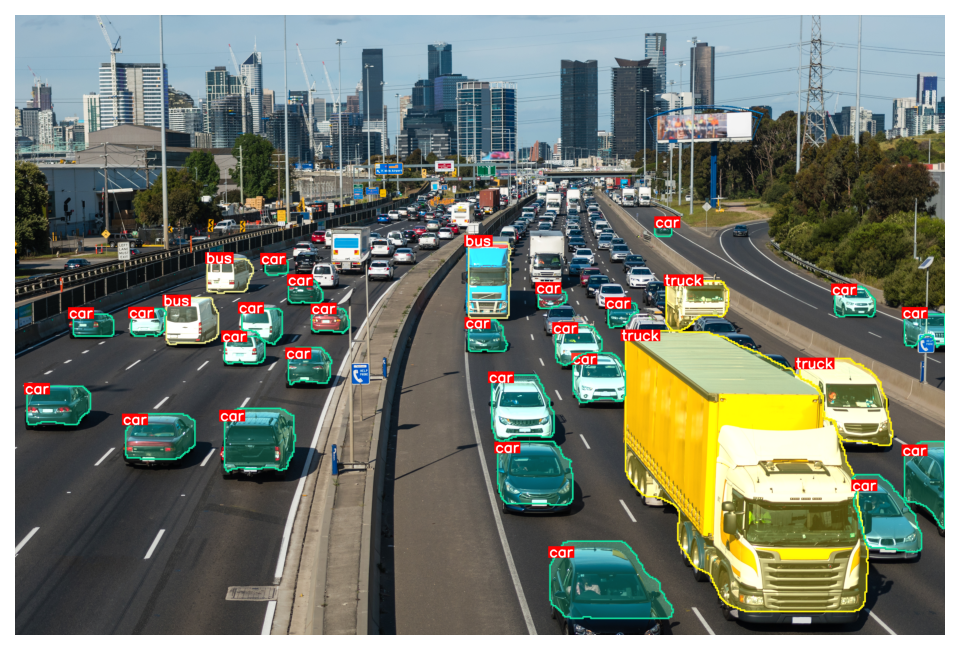

In [89]:
# Define the parameters
imgsz = 640
conf = 0.5
iou = 0.45  

# Load the YOLOv8 model
model = YOLO('yolov8m-seg.pt')  # Make sure the model file is in the correct path

# Load the image (replace 'path_to_your_image.jpg' with the actual path to your image)
img_path = 'test_images/image-test.jpg'
img = cv2.imread(img_path)

visualise_results(img, model, imgsz, conf, iou, segment=True, delta_colors=3, thickness=8, font_scale=2.5, show_boxes=False, fill_mask=True, alpha=0.3)

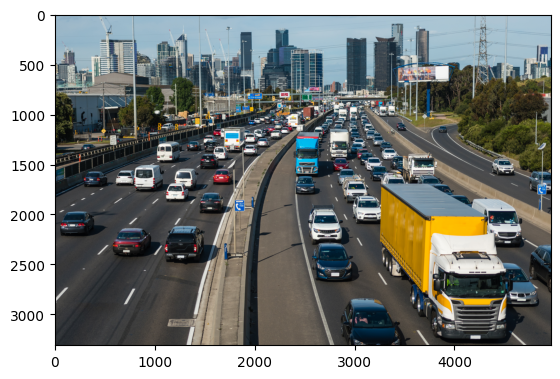

In [32]:
plt.imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB));